# Load data

In [12]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
import pandas as pd
import pickle

path_train = '../pickle/fraud/data/preprocessed_train.pkl'
path_test = '../pickle/fraud/data/preprocessed_test.pkl'
data_train:pd.DataFrame = pickle.load(open(path_train, 'rb'))
data_test = pickle.load(open(path_test, 'rb'))

print(data_train.shape)
print(data_test.shape)

(472432, 53)
(118108, 53)


## Undersampling

In [14]:
data_train = data_train.drop(data_train[data_train['isFraud'] == 0].sample(n=data_train[data_train['isFraud'] == 0].shape[0]-16421).index)
print(data_train.shape)


(32842, 53)


## Oversampling

In [15]:
from collections import Counter
from imblearn.over_sampling import ADASYN

X_train, y_train = data_train.drop('isFraud', axis=1), data_train['isFraud']
X_test, y_test = data_test.drop('isFraud', axis=1), data_test['isFraud']

ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

In [16]:
print("Original train")
print(f"0: {Counter(y_train)[0]} ({round(Counter(y_train)[0]/len(y_train)*100, 1)}%)")
print(f"1: {Counter(y_train)[1]} ({round(Counter(y_train)[1]/len(y_train)*100, 1)}%)")
print()
print("Resampled train")
print(f"0: {Counter(y_train_res)[0]} ({round(Counter(y_train_res)[0]/len(y_train_res)*100, 1)}%)")
print(f"1: {Counter(y_train_res)[1]} ({round(Counter(y_train_res)[1]/len(y_train_res)*100, 1)}%)")
print()
print("Test")
print(f"0: {Counter(y_test)[0]} ({round(Counter(y_test)[0]/len(y_test)*100, 1)}%)")
print(f"1: {Counter(y_test)[1]} ({round(Counter(y_test)[1]/len(y_test)*100, 1)}%)")

Original train
0: 16421 (50.0%)
1: 16421 (50.0%)

Resampled train
0: 16421 (50.0%)
1: 16421 (50.0%)

Test
0: 113866 (96.4%)
1: 4242 (3.6%)


# Training

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'scalers' : {
            'scaler': Categorical([None]),
        },  
        'grid' : {
            'model__max_depth': Integer(1, nb_col),
            'model__n_estimators': Integer(10, 200),
            
        },
    },

    {
        'name_clf' : 'SVC (poly)',
        'model': SVC(random_state=42, kernel='poly'),
        'scalers' : {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },

    {
        'name_clf' : 'SVC (linear)',
        'model': SVC(random_state=42, kernel='linear'),
        'scalers' : {
            'scaler': Categorical([MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },

    {
        'name_clf' : 'SVC (rbf)',
        'model': SVC(random_state=42, kernel='rbf'),
        'scalers' : {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },

    {
        'name_clf' : 'SVC (sigmoid)',
        'model': SVC(random_state=42, kernel='sigmoid'),
        'scalers' : {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },    
]

In [18]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from time import time
from utils import model_evaluation_clf
import os

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    model_path = f"../pickle/fraud/models/BayesSearchCV/{model_name}.pkl"
    model_time = f"../pickle/fraud/CPU_time/BayesSearchCV/{model_name}_time.pkl"
    if not os.path.exists(model_path) or not os.path.exists(model_time):
        print(f'Training {model_name}...')

        model = dict_clf['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_clf['scalers'],
            **dict_clf['grid']
        }

        clf = BayesSearchCV(pipeline, search_spaces=param_grid, cv=5, n_iter=20, n_jobs=-1, verbose=1, scoring='roc_auc')

        warnings.filterwarnings("ignore")
        start_time = time()
        clf.fit(X_train_res, y_train_res)
        end_time = time()
        duration = round(end_time - start_time, 1)
        print(f"CPU Time: {duration}s")

        pickle.dump(clf, open(model_path, 'wb'))
        pickle.dump(duration, open(model_time, 'wb'))
    else:
        clf = pickle.load(open(model_path, 'rb'))
        duration = pickle.load(open(model_time, 'rb'))

    
    print(f"Best params {model_name}: \n{clf.best_params_}")

    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, duration, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

    print()

Best params Random Forest: 
OrderedDict([('model__max_depth', 21), ('model__n_estimators', 200), ('scaler', None)])

Best params SVC (rbf): 
OrderedDict([('model__C', 78.62878302619048), ('scaler', StandardScaler())])

Best params SVC (sigmoid): 
OrderedDict([('model__C', 0.04745226486541268), ('scaler', StandardScaler())])



In [19]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

        Model  CPU time  Accuracy  Precision  Recall  f1-score   AUC
Random Forest    2067.2     0.963      0.496   0.992     0.661 0.977
    SVC (rbf)    1112.5     0.963      0.495   0.951     0.651 0.957
SVC (sigmoid)     828.8     0.807      0.122   0.711     0.209 0.760


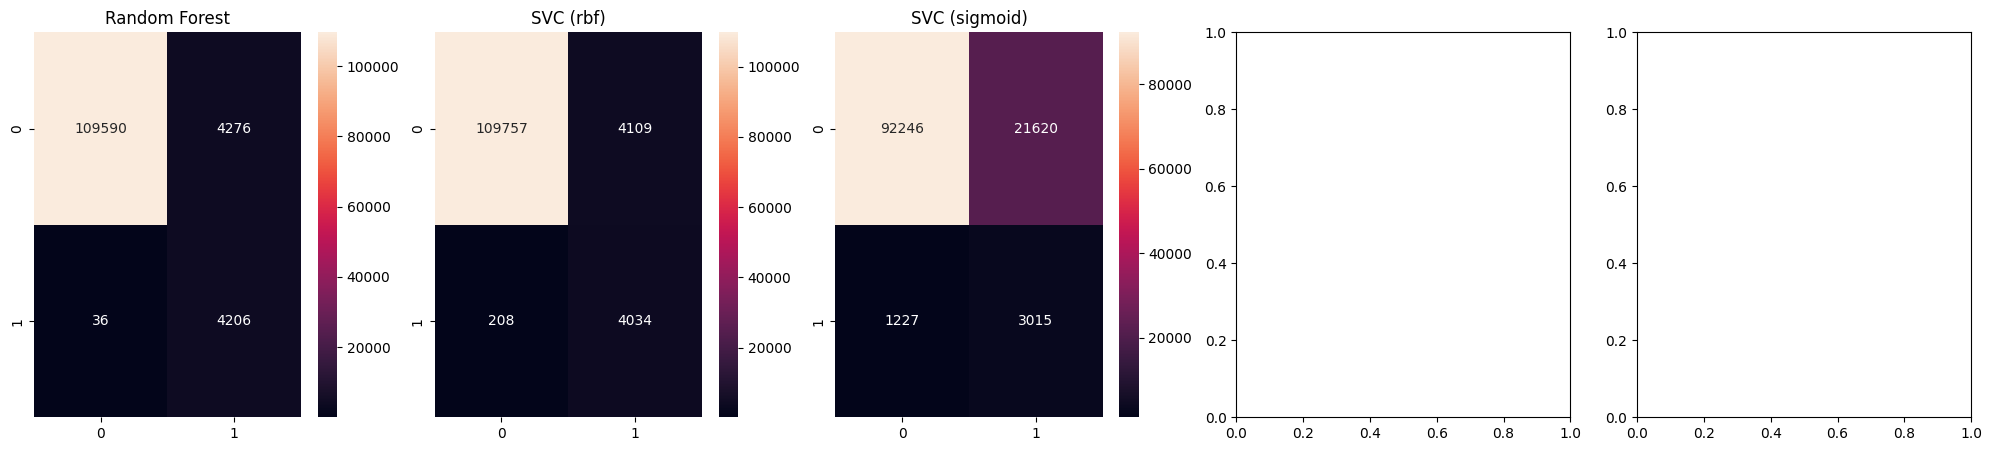

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(model_name)

plt.show()

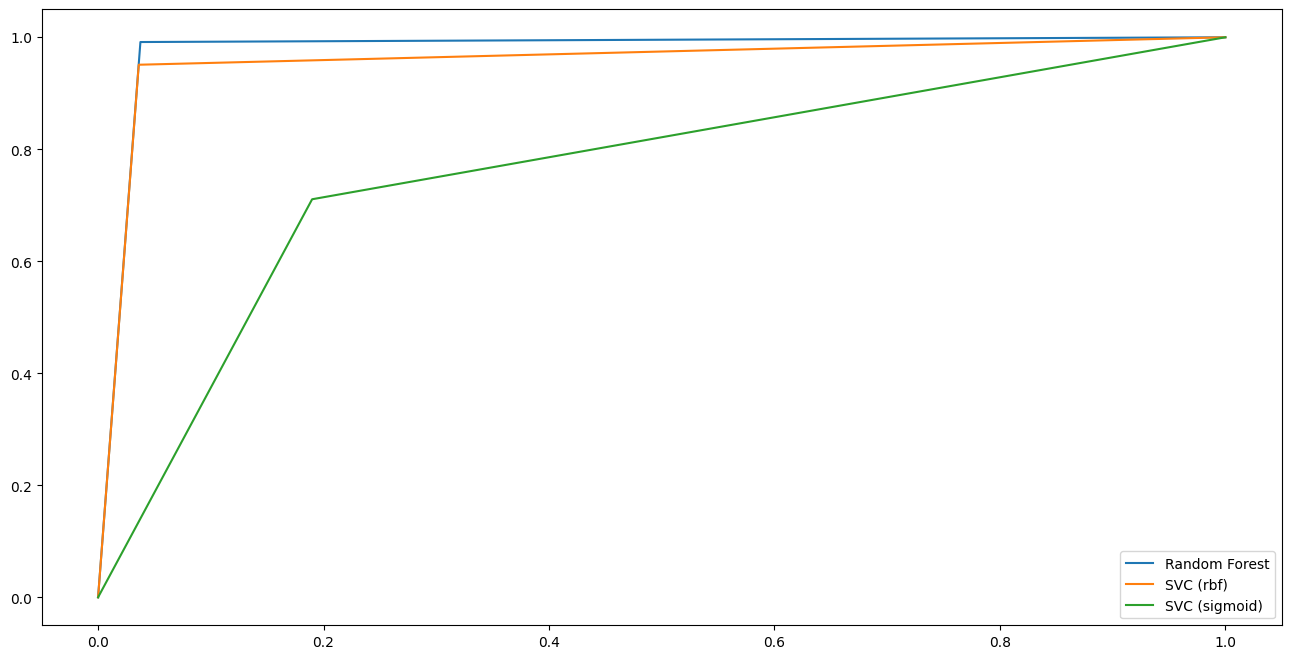

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(16, 8))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()

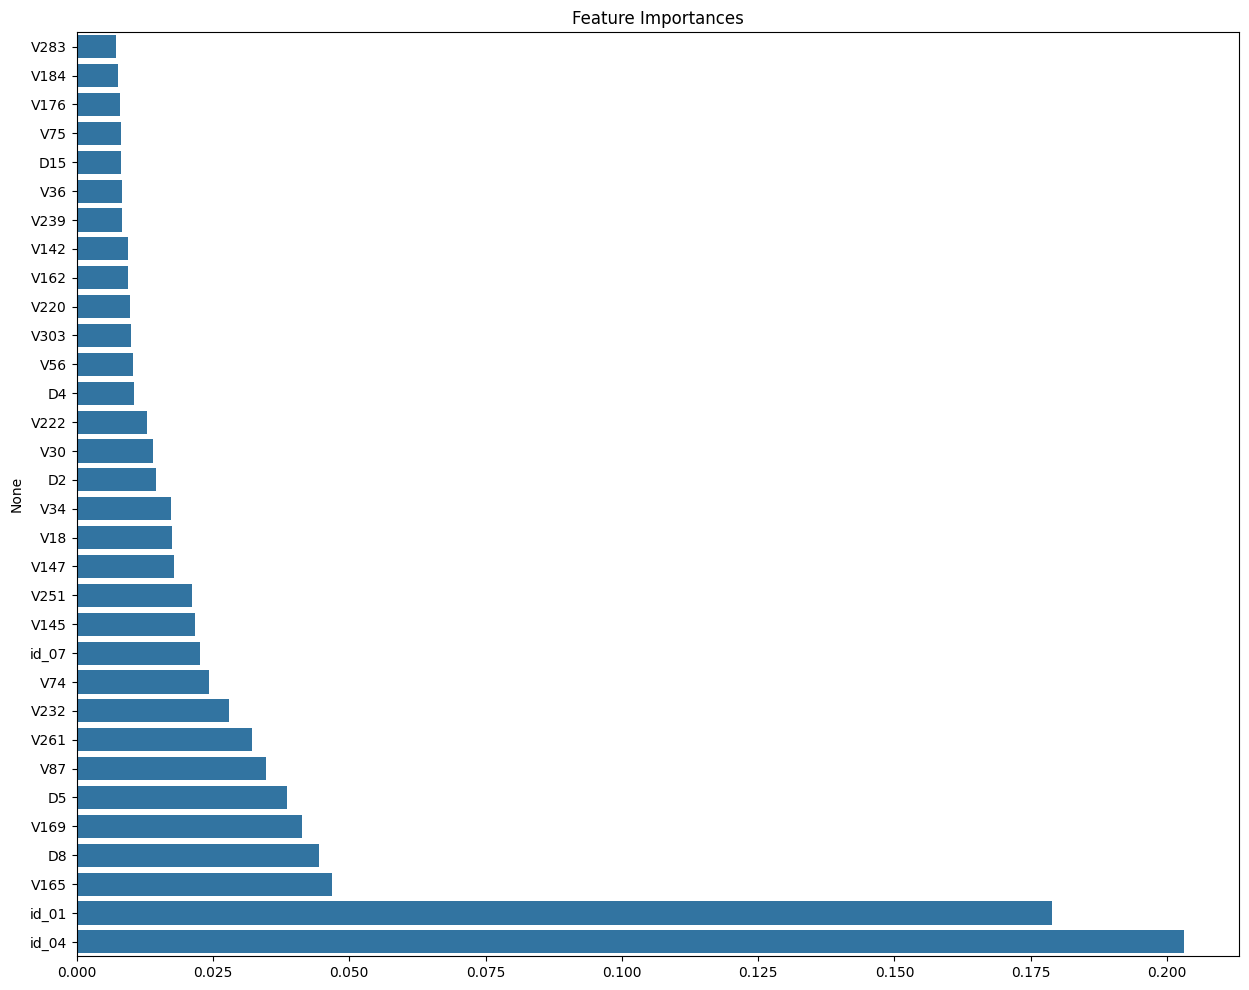

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

model = models['Random Forest']

importances = model.best_estimator_.named_steps['model'].feature_importances_
indices = importances.argsort()[20:]

plt.figure(figsize=(15, 12))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.show()